In [99]:
from scipy import stats

In [125]:
%run 'ks25_Read_epistasis.ipynb'

Running notebook 'ks01_Data_import.ipynb'...


Reading precalculated epistasis...
/Users/karen/HIS3InterspeciesEpistasis/Analysis/Karen/files_dump/epistasis_in_foursomes/



Variables: 

- ep_dict: a dictionary, Keys are tuples (mutA, mutB) and values are pandas.Series of epistasis between mutA and mutB in all backgrounds. 
Tuples (mutA, mutB) are sorted by aa_position.

- get_ep_summary: a function that takes ep_dict as an argument and applies an arbitrary function to every pd.Series object. For example, ep_summary = get_ep_summary(ep_dict, np.mean)

- get_ep_summary_by_positions: a function that uses get_ep_summary and then averages results by position_pair. For example, get_ep_summary_by_positions(ep_dict, np.max, np.mean) will apply np.max to epistasis series and then use np.mean to average across a position pair. 

Important: natlib_filtering is currently True. This can be changed in the cell #2.



In [2]:
%run 'ks21_Read_impacts_of_mutations.ipynb'


Variables: 

- fit_dict: a dictionary, keys are mutations and values are pandas.Series of fitness impacts in all backgrounds. 



In [4]:
%run 'ks20_Read_ddG.ipynb'


Variables: 
- predicted_ddG:		Pandas DataFrame with all calculated ddG (single, double and triple mutants (?)),
- predicted_doubles:		doubles only (Pandas DataFrame),
- predicted_singles:		singles only (Pandas DataFrame),
- get_ddG:			function that returns predicted ddG for a genotype
- by_position_mean_ddG:		mean ddG value at each position,
- by_position_var_ddG:		variance of predicted ddG at each position.



In [5]:
structure_file = structure_predictions_folder + 'his3_24mer_assembly/' + 'his3_swiss_24mer_assembly.pdb'

In [113]:
ddG_set1 = pd.read_table(analysis_folder + 'Sasha/rosetta_runs/170522/' + '170522_aws_ddg_talaris__mutations_to_predict_ddG__set1.csv')
ddG_set2 = pd.read_table(analysis_folder + 'Sasha/rosetta_runs/170522/' + '170522_aws_ddg_talaris__mutations_to_predict_ddG__set2.csv')
ddG_set2[:5]

,mut_list_Scer,ddG,ddg_score2,ddg_score3,ddg_score1
0,102L,3.133333,-559.211,-559.263,-559.263
1,102L:104L,9.776000,-552.603,-552.603,-552.603
2,102L:105N,5.429333,-556.991,-556.923,-556.935
3,102L:105Q,2.861000,-559.580,-559.486,-559.488
4,102L:105H,1.947000,-560.408,-560.408,-560.480


In [39]:
%run 'ks35_Read_weights.ipynb'


Variables: 

- weights: pandas.DataFrame containing weights of mutations from neural network data (column 'weight') and weights, or fitness potential, of single mutants (column 'mutant_weight')



In [126]:
ddG_set2['mut_number'] = ddG_set2['mut_list_Scer'].apply(lambda s: s.count(':') + 1)
all_doubles = ddG_set2[ddG_set2['mut_number'] == 2].copy()
all_singles = ddG_set2[ddG_set2['mut_number'] == 1].copy()
all_singles.set_index('mut_list_Scer', inplace=True)

In [236]:
def norm_fraction(value, max_fraction, threshold=100):
    return min(255. * value / max_fraction, threshold) * (255./100)

all_doubles = ddG_set2[ddG_set2['mut_number'] == 2].copy()

all_doubles['mut_list_Scer_full'] = all_doubles['mut_list_Scer'].apply(lambda s: convert_to_full_mutations(s))

all_doubles['mutA'] = all_doubles['mut_list_Scer'].apply(lambda s: s.split(':')[0])
all_doubles['mutB'] = all_doubles['mut_list_Scer'].apply(lambda s: s.split(':')[1])
all_doubles['segment'] = all_doubles['mutA'].apply(lambda m: position_to_segment[int(m[:-1])])

all_doubles['mutA_ddG'] = all_doubles['mutA'].apply(lambda m: all_singles.loc[m].ddG)
all_doubles['mutB_ddG'] = all_doubles['mutB'].apply(lambda m: all_singles.loc[m].ddG)
all_doubles['ddG_sum_of_singles'] = all_doubles.apply(lambda df: df['mutA_ddG'] + df['mutB_ddG'], axis=1)
all_doubles['ddG_double_minus_singles'] = all_doubles['ddG'] - all_doubles['ddG_sum_of_singles']

In [237]:
def get_value_from_ep_summary(ep_summary_dict, mut_comb):
    try:
        return ep_summary_dict[tuple(mut_comb.split(':'))]
    except KeyError:
        return None

    
ep_summaries = {}
ep_summaries['fraction_strong_03'] = get_ep_summary(ep_dict, lambda s: get_fraction_strong(s, mode='abs', strong_epistasis_threshold=0.3))
ep_summaries['fraction_strong_03_both_signs'] = get_ep_summary(ep_dict, lambda s: get_fraction_strong(s, mode='both_signs', strong_epistasis_threshold=0.3))

ep_summaries['fraction_strong_04'] = get_ep_summary(ep_dict, lambda s: get_fraction_strong(s, mode='abs', strong_epistasis_threshold=0.4))
ep_summaries['fraction_strong_04_both_signs'] = get_ep_summary(ep_dict, lambda s: get_fraction_strong(s, mode='both_signs', strong_epistasis_threshold=0.4))

ep_summaries['fraction_strong_05'] = get_ep_summary(ep_dict, lambda s: get_fraction_strong(s, mode='abs', strong_epistasis_threshold=0.5))
ep_summaries['fraction_strong_05_both_signs'] = get_ep_summary(ep_dict, lambda s: get_fraction_strong(s, mode='both_signs', strong_epistasis_threshold=0.5))

ep_summaries['fraction_strong_06'] = get_ep_summary(ep_dict, lambda s: get_fraction_strong(s, mode='abs', strong_epistasis_threshold=0.6))
ep_summaries['fraction_strong_06_both_signs'] = get_ep_summary(ep_dict, lambda s: get_fraction_strong(s, mode='both_signs', strong_epistasis_threshold=0.6))

ep_summaries['epistasis_mean'] = get_ep_summary(ep_dict, np.mean)
ep_summaries['epistasis_median'] = get_ep_summary(ep_dict, np.median)
ep_summaries['epistasis_std'] = get_ep_summary(ep_dict, np.std)

for k in ep_summaries:
    all_doubles[k] = all_doubles['mut_list_Scer'].apply(lambda m: get_value_from_ep_summary(ep_summaries[k], m))

In [238]:
def get_mutant_weight(m):
    to_return = weights.loc[m].weight
    if type(to_return) != np.float64:
        return None
    else:
        return to_return

all_doubles['mutA_weight'] = all_doubles['mutA'].apply(lambda m: get_mutant_weight(m))
all_doubles['mutB_weight'] = all_doubles['mutB'].apply(lambda m: get_mutant_weight(m))

### Fraction of strong

/Users/karen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


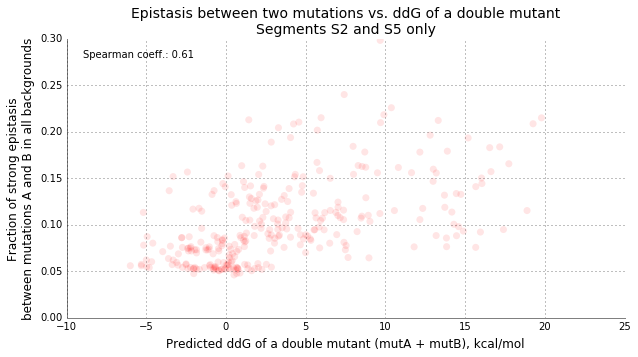

In [239]:
title = 'Epistasis between two mutations vs. ddG of a double mutant\nSegments S2 and S5 only'

x = 'ddG'
y = 'fraction_strong_04'

to_plot = all_doubles[[x, y, 'segment']].dropna()[all_doubles.segment.isin(['S2', 'S5'])]

plot_better()
plt.scatter(to_plot[x], to_plot[y], edgecolor='none', alpha=0.1, s=50, color='red')
plt.title(title, fontsize=14)
plt.text(-9, 0.28, 'Spearman coeff.: %.2f' %stats.spearmanr(to_plot[x], to_plot[y])[0], ha='left')
plt.ylim(0.0,0.3)
plt.xlabel('Predicted ddG of a double mutant (mutA + mutB), kcal/mol', fontsize=12)
plt.ylabel('Fraction of strong epistasis\nbetween mutations A and B in all backgrounds', fontsize=12)

### Std

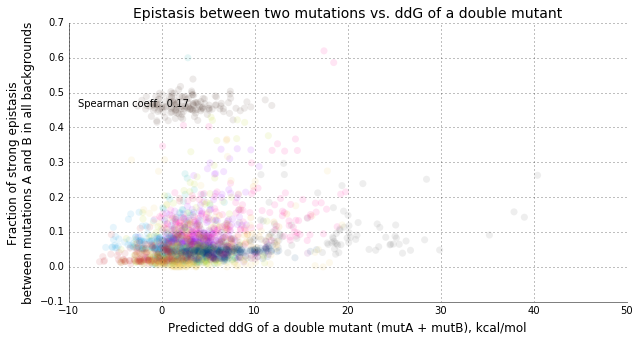

In [240]:
title = 'Epistasis between two mutations vs. ddG of a double mutant'#\nSegments S2 and S5 only'

x = 'ddG'
y = 'fraction_strong_04'

to_plot = all_doubles[[x, y, 'segment']].dropna()#[all_doubles.segment.isin(['S2', 'S5'])]

plot_better()
for row in to_plot.iterrows():
    plt.scatter(row[1][x], row[1][y], edgecolor='none', alpha=0.1, s=50, color=segment_colors[row[1]['segment'].split('_')[0]])
plt.title(title, fontsize=14)
plt.text(-9, 0.46, 'Spearman coeff.: %.2f' %stats.spearmanr(to_plot[x], to_plot[y])[0], ha='left')
# plt.ylim(0.0,0.3)
plt.xlabel('Predicted ddG of a double mutant (mutA + mutB), kcal/mol', fontsize=12)
# plt.ylabel('Standard deviation of epistasis values\nbetween mutations A and B in all backgrounds', fontsize=12)
plt.ylabel('Fraction of strong epistasis\nbetween mutations A and B in all backgrounds', fontsize=12)

In [241]:
%run 'ks23_Read_Lucas_sign_epistasis_data.ipynb'

94 positions under sign epistasis
59 positions under reciprocal sign epistasis
Pandas DataFrames available:
lucas_sign_epistasis, lucas_reciprocal_sign_epistasis

pBon threshold = 0.01
The following sets of positions are available:
all_sampled_positions, sign_epistasis_positions, reciprocal_sign_epistasis_positions


In [242]:
lucas_sign_epistasis['mutA'] = lucas_sign_epistasis.apply(lambda df: df['Perm'][0] + str(df['VarPos_absolute']) + df['Perm'][1], axis=1)
lucas_sign_epistasis['mutB'] = lucas_sign_epistasis.apply(lambda df: df['SubPerm'][0] + str(df['SubPos_absolute']) + df['SubPerm'][1], axis=1)
lucas_sign_epistasis['mut_list_Scer_full'] = lucas_sign_epistasis.apply(lambda df: ':'.join(sorted([df['mutA'], df['mutB']], key=lambda s: int(s[1:-1]))), axis=1)
lucas_sign_epistasis['mut_list_Scer'] = lucas_sign_epistasis.apply(lambda df: ':'.join(sorted([df['mutA'][1:], df['mutB'][1:]], key=lambda s: int(s[:-1]))), axis=1)
lucas_sign_epistasis.set_index('mut_list_Scer_full', inplace=True)

In [249]:
lucas_sign_epistasis

,SegN,VarPos,Perm,SubPos,SubPerm,p,logodds,X_1,X_2,X_3,...,Xf_4,VarPos_absolute,SubPos_absolute,logodds_thresholded,SubPos_interface,VarPos_interface,interface,mutA,mutB,mut_list_Scer
mut_list_Scer_full,,,,,,,,,,,,,,,,,,,,,
C141S:I143T,2,6,CS,8,IT,2.044425e-246,0.009042,85,1305,389,...,0.029460,141,143,0.009042,False,False,False,C141S,I143T,141S:143T
A141C:I143T,2,6,AC,8,IT,2.148366e-126,0.031833,94,570,373,...,0.064923,141,143,0.031833,False,False,False,A141C,I143T,141C:143T
T143V:F163V,2,8,TV,28,FV,1.422274e-115,0.003212,68,2451,95,...,0.004190,143,163,0.003212,False,False,False,T143V,F163V,143V:163V
D137S:A139P,2,2,DS,4,AP,4.495634e-108,0.058976,130,622,404,...,0.089764,137,139,0.058976,True,False,False,D137S,A139P,137S:139P
C141S:T143V,2,6,CS,8,TV,3.706988e-104,28.560606,1305,165,54,...,0.113438,141,143,5.000000,False,False,False,C141S,T143V,141S:143V
T143V:F163I,2,8,TV,28,FI,5.222215e-102,0.007270,68,2166,95,...,0.009358,143,163,0.007270,False,False,False,T143V,F163I,143V:163I
I143T:F163V,2,8,IT,28,FV,5.223764e-97,0.004709,80,2456,83,...,0.004561,143,163,0.004709,False,False,False,I143T,F163V,143T:163V
P161T:I163V,2,26,PT,28,IV,1.438273e-87,0.078987,164,430,507,...,0.087065,161,163,0.078987,False,False,False,P161T,I163V,161T:163V
I143T:F163I,2,8,IT,28,FI,4.081313e-85,0.009876,80,2147,83,...,0.009434,143,163,0.009876,False,False,False,I143T,F163I,143T:163I


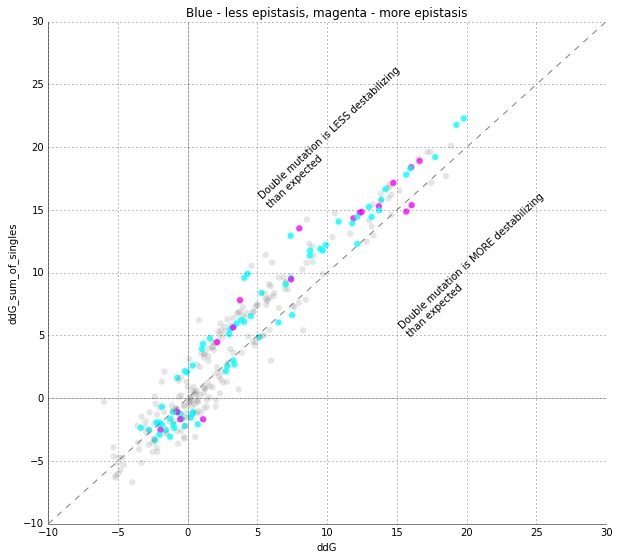

In [256]:
to_plot = all_doubles[all_doubles.segment.isin(['S2', 'S5'])]
x = 'ddG'
y = 'ddG_sum_of_singles'

plot_better(width=10, height=9)
x_line = np.arange(-10, 30, 0.1)
y_line = [v for v in x_line]
for row in to_plot.dropna().iterrows():
    try:
        sign = int(lucas_sign_epistasis.loc[row[1]['mut_list_Scer_full']].iloc[0]['pBon'] < 0.01)
        plt.scatter(row[1][x], row[1][y], edgecolor='none', alpha=0.8, s=40, color=mpl.cm.cool(255*sign))
    except:
        plt.scatter(row[1][x], row[1][y], edgecolor='none', s=40, color='gray', alpha=0.2)
plt.plot(x_line, y_line, color='gray', ls='--')
plt.axhline(0, color='gray', alpha=0.4)
plt.axvline(0, color='gray', alpha=0.4)
plt.xlim(-10,30)
plt.ylim(-10,30)
plt.xlabel(x)
plt.ylabel(y)
# plt.colorbar(mpl.cm.Greens)
plt.text(5, 25, 'Double mutation is LESS destabilizing\nthan expected', rotation=43)
plt.text(15, 15, 'Double mutation is MORE destabilizing\nthan expected', rotation=43)
plt.title('Blue - less epistasis, magenta - more epistasis')

### Fraction of strong epistasis vs. ddG of double and single mutants

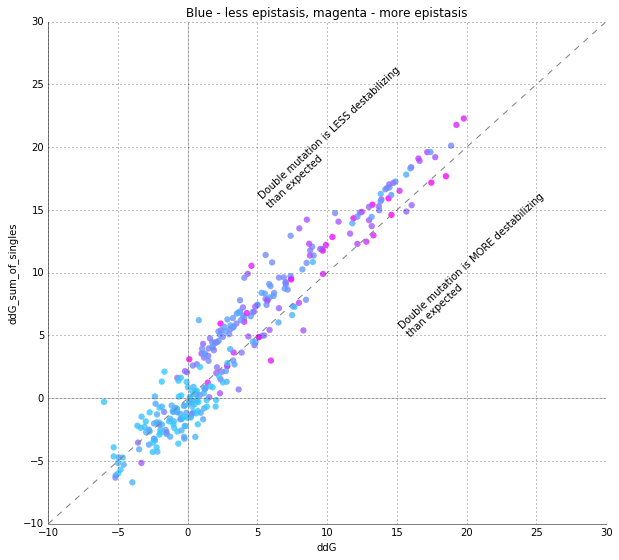

In [103]:
to_plot = all_doubles[all_doubles.segment.isin(['S2', 'S5'])]
x = 'ddG'
y = 'ddG_sum_of_singles'

plot_better(width=10, height=9)
x_line = np.arange(-10, 30, 0.1)
y_line = [v for v in x_line]
for row in to_plot.dropna().iterrows():
    plt.scatter(row[1][x], row[1][y], edgecolor='none', alpha=0.8, s=40, 
                color=mpl.cm.cool(int(row[1]['ep_fraction_strong_normalized'])))
#     break
plt.plot(x_line, y_line, color='gray', ls='--')
plt.axhline(0, color='gray', alpha=0.4)
plt.axvline(0, color='gray', alpha=0.4)
plt.xlim(-10,30)
plt.ylim(-10,30)
plt.xlabel(x)
plt.ylabel(y)
# plt.colorbar(mpl.cm.Greens)
plt.text(5, 25, 'Double mutation is LESS destabilizing\nthan expected', rotation=43)
plt.text(15, 15, 'Double mutation is MORE destabilizing\nthan expected', rotation=43)
plt.title('Blue - less epistasis, magenta - more epistasis')

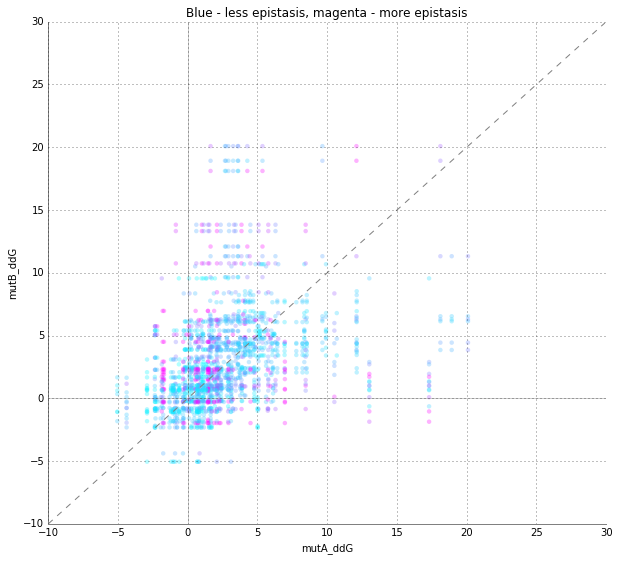

In [13]:
x = 'mutA_ddG'
y = 'mutB_ddG'

plot_better(width=10, height=9)
x_line = np.arange(-10, 30, 0.1)
y_line = [v for v in x_line]
for row in all_doubles.dropna().iterrows():
    plt.scatter(row[1][x], row[1][y], edgecolor='none', alpha=0.3, s=20, 
                color=mpl.cm.cool(int(row[1]['ep_fraction_strong_normalized'])))
#     break
plt.plot(x_line, y_line, color='gray', ls='--')
plt.axhline(0, color='gray', alpha=0.4)
plt.axvline(0, color='gray', alpha=0.4)
plt.xlim(-10,30)
plt.ylim(-10,30)
plt.xlabel(x)
plt.ylabel(y)
plt.title('Blue - less epistasis, magenta - more epistasis')
# plt.colorbar(mpl.cm.Greens)
# plt.text(5, 25, 'Double mutation is LESS destabilizing\nthan expected', rotation=43)
# plt.text(15, 15, 'Double mutation is MORE destabilizing\nthan expected', rotation=43)

In [31]:
weights

,weight,segment
mut_list_Scer,,
106D,0.909814,S1_scaled
106E,-1.538786,S1_scaled
106K,-1.029825,S1_scaled
106N,0.713743,S1_scaled
116R,0.354708,S1_scaled
117F,0.058143,S1_scaled
118G,-0.385277,S1_scaled
119S,0.005796,S1_scaled
120G,0.297664,S1_scaled
